In [2]:
import pandas as pd
import numpy as np
import pylab as pl
import os 
import datetime
import time
import re
import math as mt

%matplotlib inline
from itertools import product
from time import sleep
from dask import delayed
import dask.dataframe as dd
import seaborn as sns
#import statsmodels from tsa.stattools
#import statsmodels.tsa.stattools.acf

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf

from sklearn.datasets import load_iris
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
# Though the following import is not directly being used, it is required
# for 3D projection to work
from mpl_toolkits.mplot3d import Axes3D

from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier

#from sklearn import KNeighborsClassifier

from sklearn.cluster import KMeans
from sklearn import datasets
os.chdir(r'E:\Work\RStudio\WD\V5GJBsupport\JuceNet')

import pytz




In [3]:

class JNmodel:
    
#class analysis(JNmodel):
    
    def preliminary_analysis(self, df):
        result = df.EventString.value_counts()
        shape = df.shape
        dtype = df.dtypes
        print('event count: \n', result, '\n')
        print('df size is:  \n', shape, '\n')
        print('types of the columns are:  \n',dtype, '\n')
        
    def All_possible_patterns_count(self, df):
        unitid_event_string = df.loc[:,['UnitID', 'EventString']].copy()
        #one = df.loc[:,'EventString'].copy()
        unitid_event_string['Shifted_EventString'] = df.EventString.shift(periods = -1)
        count_different_patterns = unitid_event_string.groupby(['UnitID','EventString','Shifted_EventString']).agg({'Shifted_EventString':'count'})
        return(count_different_patterns)
        

    def bad_data_analysis(self, df):
        # Bed data row removal:
        print('the bad data will look like this: \n',  df.loc[df.PartitionKey != df.UnitID,:].head(n=2))
        value1 = df.loc[df['RowKey'].str.contains('Char', regex=True) == True,'RowKey'].shape[0]
        value2 = len(df.loc[(df.PartitionKey != df.UnitID) & (df['RowKey'].str.match('Charg') == True),:])
        value3 = len(df.loc[(df.PartitionKey != df.UnitID) & (df['RowKey'].str.match('Off') == True),:])
        value4 = len(df.loc[(df.PartitionKey != df.UnitID) & (df['RowKey'].str.match('On') == True),:])
        value5 = len(df.loc[(df.PartitionKey != df.UnitID) & (df['RowKey'].str.match('Plug') == True),:])
        total  = sum([value2,value3,value4,value5])
        value6 = len(df.loc[(df.PartitionKey != df.UnitID),:])
        final_table = pd.DataFrame([value1, value2, value3, value4, value5,total, value6] , index = ['Row_Key_Char','Charg','Off','On','Plug','sum','totlal' ])
        print(final_table)
        
 
        dft = dft.loc[dft.state == 'CA',:].copy()
        return(dft)
    


class tools(JNmodel):
    def __init__(self, filename):
        #self.path = path
        self.filename = filename
        #os.chdir('r\''+self.path)
        
# used with  my_read_csv   
    def make_serie_as_datetimein_PST_time(self, serie):
        serie = pd.to_datetime(serie)
        serie = serie.tz_localize('UTC').tz_convert('US/Pacific-New')
        return(serie)
    
    def my_read_csv(self, serie):
        #print(self.pp())
        resulting_csv = pd.read_csv(self.filename,  date_parser = self.make_serie_as_datetimein_PST_time, parse_dates = ['index'] )

        return(resulting_csv)  
    
# substitute all date for one day 1/1/2018, keeping time valid 
    def make_one_date_date(self,dd,columname):
        df= dd.copy()
        #temp  = df.loc[(df.EventString == 'PlugIn'), ['Time','UnitID']].copy()
        temp = pd.to_datetime('1/1/2018' + ' ' + df[columname].dt.time.astype('str'))
        df['One_day'] = temp
        return(df)

# introduce catecorical variable for mentioned string column   
    def make_df_faster(self, dd, categorial_string_list):
        df = dd.copy()
        print('\nOriginal Memory usage:\n', df.memory_usage(deep= True))
        df[categorial_string_list] = df[categorial_string_list].astype('category')
        print('\nMemory usage after categorising all string columns:\n', df.memory_usage(deep= True))
        return(df)
#     
    def end_and_start_time_differance_delta(self, dd, EventString, end_time, start_time, time_column):
        df = dd.loc[(dd[EventString] == end_time) | (dd[EventString] == start_time), [EventString,time_column]].copy()
        df['Shifted_Time'] = df[time_column].shift(periods = -1)
        df['Shifted_EventString'] = df[EventString].shift(periods = -1)
        df.drop(df.index[-1], axis =0, inplace =True)
        df = df.loc[df[EventString ]  == start_time ,:].copy() 
        df['delta'] = (df.Shifted_Time - df[time_column])
        df['delta'] = df.delta.dt.seconds/3600
        
        return(df)
    
    def charing_time() :
        pass
        
class JNLoadModel(JNmodel):
    
    def create_range_whith_realstart_end(self,start, end, freq):
        start_rounded = start.ceil('5min')
        end_rounded = end.floor('5min')

        dft = pd.date_range(start_rounded, end_rounded , freq=freq)#.floor('5min')

        dft = dft.insert(0, pd.Timestamp(start.round('s'), tz = 'US/Pacific-New'))
        dft = dft.insert(len(dft)+1, pd.Timestamp(end.round('s'), tz = 'US/Pacific-New'))
        dft = dft.sort_values()
        return(dft)

    def create_range_whith_rounded_end(self,start, end, freq):
        start_rounded = start.ceil('5min')
        end_rounded = end.floor('5min')
        delta1 = start_rounded - start
        delta2  =end -end_rounded
        dft = pd.date_range(start_rounded, end_rounded , freq=freq)#.floor('5min')
        dft = dft.sort_values()
        return(dft, delta1, delta2)

    def create_solid_dataframe(temp):
        seri = create_range_whith_realstart_end(temp.Time[0],temp.Shifted_Time[0],'5min')
        value = temp.Power_Value[temp.index[0]]
        seri = seri.sort_values()

        result = pd.DataFrame({'Power': value, 'UnitID':temp.UnitID[temp.index[0]], 'Status': 'ChargingStart'}, index = seri)
        result.reset_index(inplace = True)
        plug_in_out['Power'] = 0
        plug_in_out.columns = ['index','UnitID','Status','Power']

        plug_in_out.iloc[0,0] =  plugIn_index[plugIn_index.index[0]] - pd.Timedelta('1 second')

        frames = [result, plug_in_out]

        result = pd.concat(frames)
        result.set_index('index',inplace = True)

        result = result.sort_index()
        return(result)

    def par(dd):
        df = dd.copy()
        df['Time'] = df.Time.dt.round('s')
        grp  = df.groupby('snum',group_keys=True)

        ft = pd.DataFrame()
        for k, v in grp:
                temp = grp.get_group(k).sort_values('Time', ascending=True)

                plug_in_out = temp.loc[(temp.EventString == 'PlugIn') | (temp.EventString == 'PlugOut'),['Time','UnitID','EventString']].copy()
                plugIn_index = temp.loc[(temp.EventString == 'PlugIn'),'Time'].copy()
                plugOut_index = temp.loc[(temp.EventString == 'PlugOut'),'Time'].copy()

                temp = temp.loc[(temp.EventString == 'ChargingStart') | (temp.EventString == 'ChargingStop'), ['Time','snum','EventString','EventEnergy','UnitID']].copy()   
                #print(temp)
                temp['Shifted_Time'] = temp.Time.shift(periods = -1)

                temp['Shifted_EventString'] = temp.EventString.shift(periods = -1)

                temp['Shifted_EventEnergy'] = temp.EventEnergy.shift(periods = -1)
                temp.drop(temp.index[-1], axis =0, inplace =True)

                temp = temp.loc[temp.EventString   == 'ChargingStart',:].copy() 

                temp['delta'] = (temp.Shifted_Time - temp.Time)
                temp['delta'] = temp.delta.dt.seconds/3600
                temp['Shifted_EventEnergy'] = temp.Shifted_EventEnergy/1000

                temp['Power_Value'] = temp.Shifted_EventEnergy/temp.delta
                print(temp)
                df_result = pd.DataFrame()
                fr = pd.DataFrame()
                for row in temp.iterrows():
                    seri,delta1,delta2 = create_range_whith_rounded_end(self,row[1].Time,row[1].Shifted_Time,'5min')
                    #seri, delta1,delta2 = create_range_whith_realstart_end(row[1].Time,row[1].Shifted_Time,'5min')

                    value = row[1].Power_Value

                    seri = seri.sort_values()

                    result = pd.DataFrame({'Power': value, 'UnitID':row[1].UnitID, 'Status': 'ChargingStart'}, index = seri)
                    result.reset_index(inplace = True)

                    df_result = pd.concat([df_result, result])
                plug_in_out['Power'] = 0
                plug_in_out.columns = ['index','UnitID','Status','Power']

                plug_in_out.iloc[0,0] =  plugIn_index[plugIn_index.index[0]] - pd.Timedelta('1 second')

                result_fr = pd.concat([df_result, plug_in_out])

                result_fr.set_index('index',inplace = True)

                result_fr = result_fr.sort_index()
                ft = pd.concat([ft, result_fr])
                #k =k+1
                #print(k)
        return(ft)
# the result of this run is load_model_3months_better.csv having all
# load data for every 5 min interval during 24 hours for every Unit


    
class Cleaningdata(JNmodel):
    
    
    def get_rid_of_emulators(self, df):
        df = df.iloc[:,1:11]
        # Getting rid off emulators starting with 3737
        amount_of_unique_emulators = len(df.loc[df['UnitID'].str.match('3737') == True,'UnitID'].unique())
        print("amount of unique emulators is: ", amount_of_unique_emulators )
        df = df.loc[df.UnitID.str.match('3737') != True, :]
        print('amount of unique rows is:' , df.shape)
        return(df)
    
    
    def bad_data_removal(self, df):
        # Bed data row removal:
        df = df.loc[(df.PartitionKey == df.UnitID),:].copy()
        #df = self.get_rid_of_emulators(self, df)
        print(df.shape)
        return(df)
    
   
    def adding_extra_columns(self, df):
        # Adding time, time stamp
        df['Time'] = pd.to_datetime(df.Timestamp)
        df['Time'] = df.Time.dt.tz_localize('UTC').dt.tz_convert('US/Pacific-New')   
        df['dt_ts'] = df.loc[:,'Time'].astype('int64')//1e9
        df = df.iloc[:,1:12]
        # Assinging categorical variable for Event string to make plots
        df['event_bolen']= df.EventString.map({'Offline':0, 'Online':1, 'PlugIn':2, 'ChargingStart':3, 'ChargingStop':4,
       'PlugOut':5})
        df['snum'] = 0
        df['UnitID'] = df['UnitID'].astype(str)
        df['WeekDay'] =  df.Time.dt.weekday
        return(df)
    
    
    def CA_Unit_id(self, unit_zip, zip_state, df):
        zip_state =zip_state.loc[:,:].copy()
        unit_zip =unit_zip.loc[:5186,:].copy()

        zip_state['zip'] = zip_state.zip.astype('str')
        unit_zip.set_index('ZipCode', inplace =True, drop= False)

        gg  = pd.merge(unit_zip, zip_state, how = 'inner', left_on = 'ZipCode', right_on = 'zip' )
        result = gg.drop_duplicates(keep='first')
        dft = pd.merge(df, result.loc[:,['UnitID','state']].copy(), how = 'left', on = 'UnitID' )
        return (dft.loc[dft.state =='CA',:].copy())

    def data_cleaning(self, unit_zip, zip_state, df):
        df  = self.get_rid_of_emulators(self, df)
        df =  self.bad_data_removal(self, df)
        df  = self.adding_extra_columns(self, df)

        #df  = self.CA_Unit_id(self, unit_zip, zip_state, df)
        #print(df)
        return(df)
    
class creating_final_table(JNmodel):

# Finding the rows based on right charging patterns        
    def find_row_corresponding_to_partern(self, dd, colname,snum):
        df =dd.copy()
        partert_to_match_to = r"(2(?:34){1,12}5)" # ?: ignores adding the group; r"(2(?:343434343434){1,12}5)"
        resulting_df = pd.DataFrame()
        df.reset_index(inplace=True)
        string_series = df.loc[:,colname].astype('str').str.cat(sep='')
        patern_position = []

        for m in re.finditer(partert_to_match_to, string_series):
            temp = np.arange(m.start(),m.end())
            snum = snum +1
            df.loc[temp,'snum'] = snum
            frames = [resulting_df,df.loc[temp]]
            #print(snum,df.loc[temp])
            resulting_df = pd.concat(frames)
            #print(resulting_df)
        return(resulting_df,snum)

    def get_rows_for_resource_based_on_patern(self, df,column,snum = 0):
        frames = []
        result = pd.DataFrame()
        grp = df.groupby(['UnitID'],group_keys=True) 
        group_revenue=0
        for k,v in grp:
            temp = grp.get_group(k).sort_values('Time', ascending=True)
            temp_df, snum = self.find_row_corresponding_to_partern(self,temp, column,snum)
            #print(temp_df)
            #print(temp_df['snum']= snum)
            frames = [result,temp_df]
            #print(temp_df)
            result = pd.concat(frames)
            
        #print('result',result )
        result.set_index('index', inplace=True)
        #print('print', result)
        return(result)

    
class smart_data_cleaning(JNmodel):    
                                        # Detailed analytics with data removal. 
        
# Delete session with large power, more that 10kw.

    def corrected_power_value(self, df):
        #df.set_index('index', inplace = True)
        # get rid of sessions with power more than 10Kw
        group_session = df.loc[df.EventString == 'ChargingStop', ['UnitID', 'EventString','snum','EventDuration','EventEnergy','power']].groupby(['snum']).agg({'EventDuration' :'sum','EventEnergy':'sum'})
        group_session['result'] = (group_session.EventEnergy/1000)/(group_session.EventDuration/3600)
        gg = group_session.loc[group_session.result > 10,:].index.tolist()
        return(df.loc[-df.snum.isin(gg),:].copy())
    
# getting rid of sessions where charign time is not equal to sum of event duration:
   
    def total_charing_time_equal_of_charingStopEventduartion(self, df):
        EventDuration = df.loc[df.EventString =='ChargingStop', :].groupby(['snum']).agg({'EventDuration':'sum'})
        totlal_ChargingTime = df.loc[df.EventString =='ChargingStop', :].groupby(['snum']).agg({'ChargingTime':'max'})
  
        duration_sum_check = pd.DataFrame({'EventDuration':EventDuration.EventDuration,'ChargingTime':totlal_ChargingTime.ChargingTime })
        print(duration_sum_check.head(n=10))

        E1 = duration_sum_check.loc[duration_sum_check.EventDuration == duration_sum_check.ChargingTime,:]
        E2 = duration_sum_check.loc[duration_sum_check.EventDuration != duration_sum_check.ChargingTime,:]

        df_with_correct_sessions = df.loc[df.snum.isin(E1.index.get_values()) == True,:].copy()
        df_with_wrong_sessions = df.loc[df.snum.isin(E2.index.get_values()) == True,:].copy()
        return(E2.index.get_values(), df_with_correct_sessions, df_with_wrong_sessions)
    

# getting rid of sessions with abnormal enery values.
    
    def total_energy_equal_to_sum_of_charingStopEnergy(self, df):
        chagrinstop = df.loc[df.EventString =='ChargingStop', :].groupby(['snum']).agg({'EventEnergy':'sum'})
        totlal_energy = df.loc[df.EventString =='ChargingStop', :].groupby(['snum']).agg({'TotalEnergy':'max'})
        print(chagrinstop.head(n=5),'\n\n',totlal_energy.head(n=5))
        energy_sum_check = pd.DataFrame({'charing_stop':chagrinstop.EventEnergy,'total_energy':totlal_energy.TotalEnergy })
        E1 = energy_sum_check.loc[energy_sum_check.charing_stop==energy_sum_check.total_energy,:]
        E2 = energy_sum_check.loc[energy_sum_check.charing_stop!=energy_sum_check.total_energy,:]
        print('number of sesions with total energy equal to sum of charing energy:\n', E1.shape)
        print('number of sesions with total energy not equal to sum of charing energy:\n', E2.shape)

        df_with_correct_sessions = df.loc[df.snum.isin(E1.index.get_values()) == True,:].copy()
        df_with_wrong_sessions = df.loc[df.snum.isin(E2.index.get_values()) == True,:].copy()
        #new_df = df.loc[-df.snum.isna(E2.index)]
        return(energy_sum_check.head(n=5),E2.index.get_values() ,df_with_correct_sessions,df_with_wrong_sessions)

# Getting rid of sessions where Event duation for plug_out is equal delta df.time

    def total_time_equal_to_TotalDration(self, df):
        print('\n\n\n AAAAAAAAAAAAAA','\n\n\n' ,df.head(n=2))
        #df.reset_index(inplace=True)
        df.set_index('snum', inplace=True)
        PluginTime = df.loc[df.EventString == 'PlugIn', 'Time'].copy()
        PlugOutTime = df.loc[df.EventString == 'PlugOut', 'Time'].copy()
        print('\n\n\n BBBBBBB','\n\n\n' ,df.head(n=2))
        
        #print(PluginTime.head(n=2),PluginTime.dtypes)
        #print(PluginTime.head(n=2),  PlugOutTime.dtypes)

        delta_df = pd.concat([PluginTime,PlugOutTime], axis = 1)
        delta_df.columns = ['PluginTime','PlugOutTime']
        
        #print(delta_df.head(n=3))
        
        delta_df['delta'] = delta_df.PlugOutTime - delta_df.PluginTime
        delta_df['delta'] = delta_df.delta.dt.seconds 

        # Plugged sessions duration
        Event_Duration_plug_in = df.loc[df.EventString == 'PlugOut', 'EventDuration'].copy()

        delta_df = pd.concat([delta_df, Event_Duration_plug_in ], axis=1)
        df.reset_index(inplace=True)
        df.set_index('index', inplace=True)

        E1  = delta_df.loc[(delta_df.delta - delta_df.EventDuration) < 1,:].copy()
        E2  = delta_df.loc[(delta_df.delta - delta_df.EventDuration) > 1,:].copy()
        
        df_with_correct_timing = df.loc[df.snum.isin(E1.index.get_values()) == True,:].copy()
        df_with_wrong_timing = df.loc[df.snum.isin(E2.index.get_values()) == True,:].copy()
        return(df_with_correct_timing, df_with_correct_timing.shape )
        
    def more_data_removal(self, df):
        df = self.corrected_power_value(self, df)
        index, correct_df, wrong_df = self.total_charing_time_equal_of_charingStopEventduartion(self, df)
        energy_sum_check, index, correct_df, wrong_df = self.total_energy_equal_to_sum_of_charingStopEnergy(self, correct_df)
        correct_df, correct_df_shape = self.total_time_equal_to_TotalDration(self, correct_df)
        
       
        return(correct_df)
    
    
class JN_model_analytics:
    
    def make_one_date_date(self,series):
        #temp  = df.loc[(df.EventString == 'PlugIn'), ['Time','UnitID']].copy()
        temp = pd.to_datetime('1/1/2018' + ' ' + series.dt.time.astype('str'))
        return(temp)
        
    
    def plug_in_out_plot(self, df):
        temp  = df.loc[(df.EventString == 'PlugIn'), ['Time','UnitID']].copy()
        temp['day_index'] = pd.to_datetime('1/1/2018' + ' ' + df.Time.dt.time.astype('str'))
        print(temp.shape)
        
        temp1  = df.loc[(df.EventString == 'PlugOut'), ['Time','UnitID']].copy()
        temp1['day_index'] = pd.to_datetime('1/1/2018' + ' ' + df.Time.dt.time.astype('str'))
        print(temp1.shape)
        
        PlugIn =temp.day_index
        PlugOut = temp1.day_index
        
        aa  =  pd.to_timedelta(a).astype('timedelta64[s]')
        bb  = pd.to_timedelta(b).astype('timedelta64[s]')
        plt.figure(figsize=(15,15))

        plt.xlabel('PlugIn', fontsize=18)
        plt.ylabel('PlugOut', fontsize=16)
        plt.hist2d(aa, bb, (96,96), cmap=plt.cm.jet)
        plt.colorbar()


        return(PlugIn,PlugOut)


    def plug_in_distribution(self, df):
        
        temp  = df.loc[(df.EventString == 'PlugIn'), ['Time','UnitID','WeekDay']].copy()
        temp['day_index'] = pd.to_datetime('1/1/2018' + ' ' + df.Time.dt.time.astype('str'))
        temp['day_index_norm'] = temp.day_index - temp.day_index.dt.normalize()
        temp.reset_index(inplace =True)
        temp.set_index('day_index', inplace =True)
        rr = temp.UnitID.resample('10t').count()
        rr_sum = sum(rr)
        rr2 = rr/rr_sum
        print( rr2.resample('20t').sum().plot())
        return(rr2)
        
    def plug_out_distribution(self, df):
        temp  = df.loc[(df.EventString == 'PlugOut'), ['Time','UnitID','WeekDay']].copy()
        temp['day_index'] = pd.to_datetime('1/1/2018' + ' ' + df.Time.dt.time.astype('str'))
        temp['day_index_norm'] = temp.day_index - temp.day_index.dt.normalize()
        temp.reset_index(inplace =True)
        temp.set_index('day_index', inplace =True)
        rr = temp.UnitID.resample('10t').count()
        rr_sum = sum(rr)
        rr2 = rr/rr_sum
        print( rr2.resample('20t').sum().plot())#.count().plot())
        return(rr2)

    def energy_pre_seesion_distribution(self, dd):
        df = dd.loc[:,:].copy()  
        df['EventEnergy'] = df.EventEnergy/1000
        #df = df.loc[(df.EventEnergy > 0) & (df.EventEnergy < 60) , :].copy()
        group = df.groupby(['UnitID','snum']).agg({'EventEnergy':'sum' })
        group = group.loc[(group.EventEnergy >0) & (group.EventEnergy < 60), :].copy()
        print ('\n mean:',np.mean(group.EventEnergy), '\n std:',np.std(group.EventEnergy))
       
        n, bins, patches = plt.hist(group.EventEnergy, 100, normed=1, facecolor='green', alpha=0.75)
        #print(group)
        #a = np.hstack((rng.normal(size=1000),             rng.normal(loc=5, scale=2, size=1000)))
        #print(group.EventEnergy.plot.hist(bins=2000), range = (0,100))
        return(pd.Series(n), pd.Series(bins) )
    
    def plugged_time_pre_seesion_distribution(df):
        PlugIn = df.loc[(df.EventString == 'PlugIn'), ['snum','UnitID','Time']].copy()
        PlugOut  = df.loc[(df.EventString == 'PlugOut'), ['snum','UnitID','Time']].copy()
        PlugIn.set_index('snum', inplace = True )
        PlugOut.set_index('snum', inplace = True )
        
        result = PlugIn
        result 
        result['PlugOut'] =  PlugOut.Time
        result['Delta']  =  (result.PlugOut - result.Time)
        result['Delta'] = result.Delta.dt.seconds/3600
        
        n, bins, patches = plt.hist(result.Delta, 100, normed=1, facecolor='green', alpha=0.75)
                
        return(pd.Series(n), pd.Series(bins) )
             
    def plug_in_time(self, df):
        temp  = df.loc[(df.EventString == 'PlugIn'), ['Time','UnitID']].copy()
        temp['day_index'] = pd.to_datetime('1/1/2018' + ' ' + df.Time.dt.time.astype('str'))
        temp['day_index_norm'] = temp.day_index - temp.day_index.dt.normalize()
 
        temp.reset_index(inplace =True)
        temp.set_index('UnitID', inplace =True)  
        groups = temp.loc[:,'day_index_norm'].groupby(level = 0)

        time_diff = groups.apply(np.mean)
        time_diff = pd.to_datetime('1/1/2018') + time_diff
        return(time_diff)

    def plug_out_time(self, df):
        temp  = df.loc[(df.EventString == 'PlugOut'), ['Time','UnitID']].copy()
        temp['day_index'] = pd.to_datetime('1/1/2018' + ' ' + df.Time.dt.time.astype('str'))
        temp['day_index_norm'] = temp.day_index - temp.day_index.dt.normalize()
        #print(temp.head(n=10))
        temp.reset_index(inplace =True)
        temp.set_index('UnitID', inplace =True)  
        groups = temp.loc[:,'day_index_norm'].groupby(level = 0)

        time_diff = groups.apply(np.mean)
        time_diff = pd.to_datetime('1/1/2018') + time_diff
        return(time_diff)
    
    
    def energy_per_JB(self, dd):
        
        df = dd.loc[:,:].copy()  
        df['EventEnergy'] = df.EventEnergy/1000
        group = df.groupby(['UnitID','snum']).agg({'EventEnergy':'sum' })
        energy_mean  = group.groupby(level=0).mean()
        energy_std  = group.groupby(level=0).std()
        return(energy_mean, energy_std)
    
    def input_for_brain(self, df):
  
        nn = self.plug_in_time(self, df)
        out = self.plug_out_time(self, df)
        energy_shit, energy_std = self.energy_per_JB(self, df)
        
        result = pd.concat([nn,out ,energy_shit.EventEnergy, energy_std.EventEnergy] , axis =1)
        result.columns=['PlugIn','PlugOut','Energy, kWH' ,'Energy, STD']
        result['Delta, kWh'] = result.PlugOut - result.PlugIn
        result['Delta, kWh'] = result.delta.dt.seconds/3600
        return(result)
    
    
    def knn(self, df):
        #prepare data set 
        return(2)
        
# distributions: 


         
# analitics on clean table
jnm = JNmodel
gugu = Cleaningdata
cft= creating_final_table
sdc = smart_data_cleaning
anl = JN_model_analytics
jlm = JNLoadModel
tls = tools('load_model_3months_better.csv' )
  

In [27]:
#fff  = cft.get_rows_for_resource_based_on_patern(cft, ff, 'event_bolen',0)

In [370]:
ff = tools.make_df_faster(tls,ff, 'UnitID')
ff = tools.make_df_faster(tls,ff, 'EventString')


Original Memory usage:
 Index             49841528
RowKey           566947381
Timestamp        504645471
UnitID           511951608
EventString      408133062
EventDuration     49841528
EventEnergy       49841528
ChargingTime      49841528
TotalEnergy       49841528
Duration          49841528
Time              49841528
dt_ts             49841528
event_bolen       49841528
snum              49841528
WeekDay           49841528
dtype: int64

Memory usage after categorising all string columns:
 Index             49841528
RowKey           566947381
Timestamp        504645471
UnitID            12964809
EventString      408133062
EventDuration     49841528
EventEnergy       49841528
ChargingTime      49841528
TotalEnergy       49841528
Duration          49841528
Time              49841528
dt_ts             49841528
event_bolen       49841528
snum              49841528
WeekDay           49841528
dtype: int64

Original Memory usage:
 Index             49841528
RowKey           566947381
Timest

In [8]:
v = tls.my_read_csv( 'index' ) 


In [376]:
len(fff.UnitID.unique())

5169

In [372]:
fff.to_csv('Juice_net_clean_Data_USA.csv')

In [323]:
pluged_time = tools.end_and_start_time_differance_delta(tls, vv,'Status','PlugOut', 'PlugIn', 'index')

     Status                     index
0    PlugIn 2017-03-03 14:47:15-08:00
39  PlugOut 2017-03-03 18:24:16-08:00


In [332]:
#n, bins, patches = plt.hist(pluged_time.delta, 400, normed=1, facecolor='green', alpha=0.75)
      

In [275]:
#df=pd.read_csv("dfl.csv")
#unit_zip = pd.pandas.read_excel("unit_zip.xlsx", sheetname = 'unit_zip')
#zip_state = pd.read_csv("Cazip.csv")
#unit_zip['UnitID'] = unit_zip.UnitID.astype('str')

In [4]:
#tls =tools('Juice_net_clean_Data_CA.csv') 
#fff = pd.read_csv("Juice_net_clean_Data_CA.csv" , date_parser = tls.make_serie_as_datetimein_PST_time, parse_dates = ['Time'] )
#fff = pd.read_csv("Juice_net_clean_Data_USA.csv" , date_parser = tls.make_serie_as_datetimein_PST_time, parse_dates = ['Time'] )
#df = pd.read_csv("dfl.csv" )


E:\Work\Python\Anaconda\done\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#ff = Cleaningdata.data_cleaning(gugu, unit_zip, zip_state, df)
#fff  = cft.get_rows_for_resource_based_on_patern(cft, ff.head(n=1000), 'event_bolen',0)
#fff.to_csv('Juice_net_clean_Data_USA.csv')


#ff = Cleaningdata.data_cleaning(gugu, unit_zip, zip_state, df)
#fff_ca = Cleaningdata.CA_Unit_id(gugu, unit_zip, zip_state, df)


#fff.to_csv("Juice_net_clean_Data_CA.csv")

#tls =tools('Juice_net_clean_Data_CA.csv') 
fff_ca = pd.read_csv("Juice_net_clean_Data_CA.csv" , date_parser = tls.make_serie_as_datetimein_PST_time, parse_dates = ['Time'] )


#result = smart_data_cleaning.more_data_removal(sdc, fff)
#result['Month'] = result.Time.dt.month


#snum_monht_list = result.loc[result.Month.isin([3,4,5]),'snum'].copy()
#snum_monht_list = snum_monht_list.tolist()
#xx = result.loc[result.snum.isin(snum_monht_list),:].copy()



In [5]:
#fff_ca=fff

In [6]:
fff_ca.head(n=2)

,index,RowKey,Timestamp,UnitID,EventString,EventDuration,EventEnergy,ChargingTime,TotalEnergy,Duration,Time,dt_ts,event_bolen,snum,WeekDay,state
0,4,17-03-03 14:47:15 9038472 0150F9FD,2017-03-03T22:47:15.910Z,0100000100000046495017126501,PlugIn,0.0,0.0,0.0,0.0,NaN,2017-03-03 14:47:15.910000-08:00,1.488581e+09,2,1,4,CA
1,5,17-03-03 14:47:19 8412462 0150FBE2,2017-03-03T22:47:19.830Z,0100000100000046495017126501,ChargingStart,0.0,0.0,0.0,0.0,NaN,2017-03-03 14:47:19.830000-08:00,1.488581e+09,3,1,4,CA


In [5]:
fff_ca.shape

(918570, 16)

In [7]:
ff= tls.make_df_faster(fff_ca,'UnitID')
fff_ca= tls.make_df_faster(ff,'EventString')
fff_c = fff_ca


Original Memory usage:
 Index                  80
index             7348560
RowKey           83589870
Timestamp        74404170
UnitID           77858996
EventString      61553595
EventDuration     7348560
EventEnergy       7348560
ChargingTime      7348560
TotalEnergy       7348560
Duration          7348560
Time              7348560
dt_ts             7348560
event_bolen       7348560
snum              7348560
WeekDay           7348560
state            54195630
dtype: int64

Memory usage after categorising all string columns:
 Index                  80
index             7348560
RowKey           83589870
Timestamp        74404170
UnitID            2016504
EventString      61553595
EventDuration     7348560
EventEnergy       7348560
ChargingTime      7348560
TotalEnergy       7348560
Duration          7348560
Time              7348560
dt_ts             7348560
event_bolen       7348560
snum              7348560
WeekDay           7348560
state            54195630
dtype: int64

Original M

In [8]:
fff_c.shape

(918570, 16)

In [9]:
fff_c.head(n=2)

,index,RowKey,Timestamp,UnitID,EventString,EventDuration,EventEnergy,ChargingTime,TotalEnergy,Duration,Time,dt_ts,event_bolen,snum,WeekDay,state
0,4,17-03-03 14:47:15 9038472 0150F9FD,2017-03-03T22:47:15.910Z,0100000100000046495017126501,PlugIn,0.0,0.0,0.0,0.0,NaN,2017-03-03 14:47:15.910000-08:00,1.488581e+09,2,1,4,CA
1,5,17-03-03 14:47:19 8412462 0150FBE2,2017-03-03T22:47:19.830Z,0100000100000046495017126501,ChargingStart,0.0,0.0,0.0,0.0,NaN,2017-03-03 14:47:19.830000-08:00,1.488581e+09,3,1,4,CA


In [10]:
fff_c.Time.dtypes

datetime64[ns, US/Pacific-New]

In [11]:
tt = tls.my_read_csv(tls.filename)
start  = pd.Timestamp("2017-03-01 00:00:00.000000-08:00", tz = 'US/Pacific-New')
start = pd.to_datetime(start)
end  = pd.Timestamp("2017-03-11 00:00:00.000000-08:00", tz = 'US/Pacific-New')
end = pd.to_datetime(end)
xx = tt
xx = xx.loc[(xx['index'] < end) &(xx['index'] > start) ,:]
xx.set_index('index', inplace=True,drop=False)

xx = xx.loc[:,['index','Power']]
xx = xx.resample('5t').sum()
xx= xx.reset_index()
xx['weekday'] = xx['index'].dt.weekday

xx.set_index('index', inplace=True,drop=True)
#tt = pd.get_dummies(xx, columns = ['weekday'], drop_first = True)
tt  =xx.loc[:,["Power"]]
tt.loc[tt.Power==np.inf,:] = 345

In [ ]:
train, test = X[0:size], X[size:len(X)]

Test MSE: 6158.382


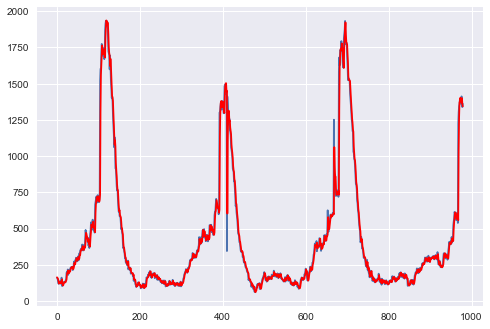

In [15]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
 
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
series = tt#read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

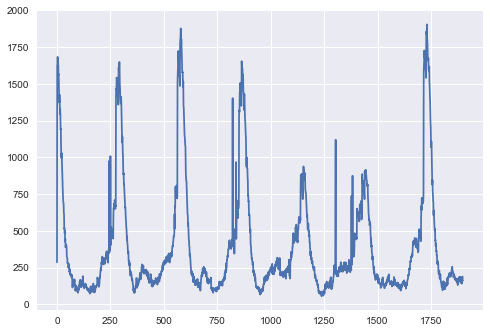

In [16]:
pyplot.plot(train)

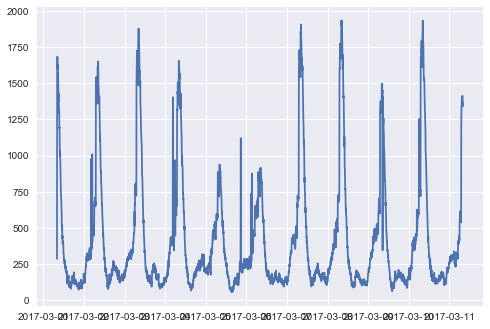

In [7]:
pyplot.plot(tt)

In [18]:
model = ARIMA(history, order=(1,1,0))
model_fit.forecast()

(array([ 138.70415137]),
 array([ 79.33035362]),
 array([[ -16.78048461,  294.18878735]]))